In [2]:
pathmc="/eos/user/h/hsharma/PythiaFIles/dummySets/mc_events.csv"
pathdata="/eos/user/h/hsharma/PythiaFIles/dummySets/real_events.csv"


import numpy as np
import pandas as pd
import matplotlib as plt
# Set random seed for reproducibility
np.random.seed(42)

# Number of events
N_real = 10000  # Real dataset size
N_mc = 10000    # MC dataset size

# Generate "real" event data (from a slightly different true distribution)
real_pT = np.random.normal(loc=50, scale=10, size=N_real)  # Centered at 50 GeV
real_y = np.random.normal(loc=0.2, scale=1, size=N_real)      # Centered at 0
real_m = np.random.normal(loc=200, scale=20, size=N_real)   # Mass around 200 GeV

# Generate "MC" event data (with slight systematic shift)
mc_pT = np.random.normal(loc=52, scale=11, size=N_mc)  # Shifted mean + wider spread
mc_y = np.random.normal(loc=0.1, scale=1.1, size=N_mc)  # Small shift in rapidity
mc_m = np.random.normal(loc=195, scale=22, size=N_mc)   # Mass shifted down

# Create pandas DataFrames
real_data = pd.DataFrame({"pT": real_pT, "y": real_y, "m": real_m})
mc_data = pd.DataFrame({"pT": mc_pT, "y": mc_y, "m": mc_m})

# Save to CSV files
real_data_path = "/mnt/data/real_events.csv"
mc_data_path = "/mnt/data/mc_events.csv"

real_data.to_csv(pathmc, index=False)
mc_data.to_csv(pathdata, index=False)



array([[<Axes: title={'center': 'pT'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'm'}>, <Axes: >]], dtype=object)

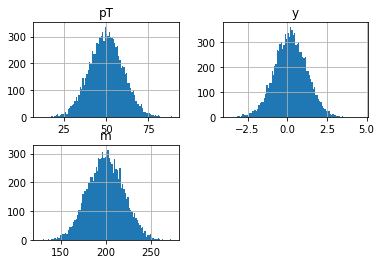

In [3]:
real_data[['pT','y','m']].hist(bins=100)

array([[<Axes: title={'center': 'pT'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'm'}>, <Axes: >]], dtype=object)

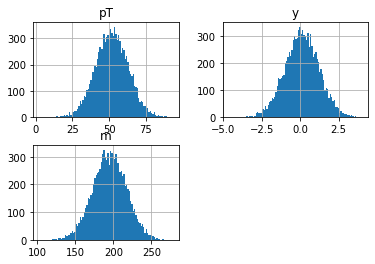

In [4]:
mc_data[['pT','y','m']].hist(bins=100)

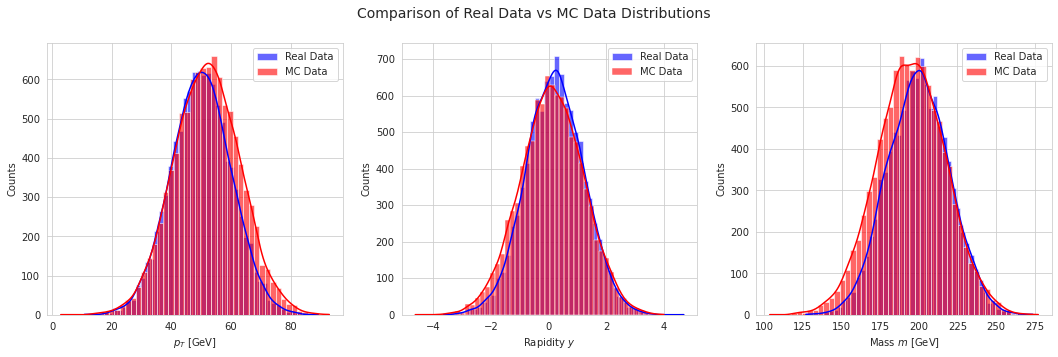

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define variable names and labels
variables = ["pT", "y", "m"]
labels = [r"$p_T$ [GeV]", r"Rapidity $y$", r"Mass $m$ [GeV]"]

# Plot distributions
for i, var in enumerate(variables):
    sns.histplot(real_data[var], bins=50, kde=True, color="blue", label="Real Data", ax=axes[i], alpha=0.6)
    sns.histplot(mc_data[var], bins=50, kde=True, color="red", label="MC Data", ax=axes[i], alpha=0.6)
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("Counts")
    axes[i].legend()

# Show the plots
plt.suptitle("Comparison of Real Data vs MC Data Distributions", fontsize=14)
plt.show()


In [19]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaler.fit(real_data)

# Create pandas DataFrames
real_data = pd.DataFrame({"pT": real_pT, "y": real_y, "m": real_m})
mc_data = pd.DataFrame({"pT": mc_pT, "y": mc_y, "m": mc_m})

# ------ Convert full data to tensors -----------------------
real_data_scaled = scaler.transform(real_data)
real_data_scaled = pd.DataFrame(real_data_scaled, columns=mc_data.columns)

mc_data_scaled = scaler.transform(mc_data)
mc_data_scaled = pd.DataFrame(mc_data_scaled, columns=mc_data.columns)

# Convert to tensors
real_data_scaled_tensor = torch.tensor(real_data_scaled.values, dtype=torch.float32)
mc_data_scaled_tensor = torch.tensor(mc_data_scaled.values, dtype=torch.float32)

#-----------------------------------------------------------


# ------ Train and Test sets -------------------
# Split real and MC data into training and validation sets
real_train, real_val = train_test_split(real_data, test_size=0.3, random_state=42)
mc_train, mc_val = train_test_split(mc_data, test_size=0.3, random_state=42)

# --- STEP 1: Fit a single scaler on real training data ---
scaler = StandardScaler()
scaler.fit(real_train)  # Fit only on training data to prevent data leakage

# --- STEP 2: Transform all datasets using the same scaler ---
real_train_scaled = scaler.transform(real_train)
real_val_scaled = scaler.transform(real_val)
mc_train_scaled = scaler.transform(mc_train)
mc_val_scaled = scaler.transform(mc_val)

# Convert scaled data back to DataFrames (optional)
real_train_scaled = pd.DataFrame(real_train_scaled, columns=real_data.columns)
real_val_scaled = pd.DataFrame(real_val_scaled, columns=real_data.columns)
mc_train_scaled = pd.DataFrame(mc_train_scaled, columns=mc_data.columns)
mc_val_scaled = pd.DataFrame(mc_val_scaled, columns=mc_data.columns)

# --- STEP 3: Convert to PyTorch tensors ---
real_train_tensor = torch.tensor(real_train_scaled.values, dtype=torch.float32)
real_val_tensor = torch.tensor(real_val_scaled.values, dtype=torch.float32)
mc_train_tensor = torch.tensor(mc_train_scaled.values, dtype=torch.float32)
mc_val_tensor = torch.tensor(mc_val_scaled.values, dtype=torch.float32)

# Convert to tensors
# real_data_scaled_tensor = torch.tensor(real_data_scaled.values, dtype=torch.float32)
# mc_data_scaled_tensor = torch.tensor(mc_data_scaled.values, dtype=torch.float32)


# --- STEP 4: Verify Scaling ---
print("Training Data Mean:", real_train_tensor.mean(dim=0))
print("Training Data Std Dev:", real_train_tensor.std(dim=0))
print("Validation Data Mean:", real_val_tensor.mean(dim=0))
print("Validation Data Std Dev:", real_val_tensor.std(dim=0))


Training Data Mean: tensor([ 2.1798e-09, -1.6349e-09,  0.0000e+00])
Training Data Std Dev: tensor([1.0001, 1.0001, 1.0001])
Validation Data Mean: tensor([-0.0255,  0.0322, -0.0428])
Validation Data Std Dev: tensor([1.0021, 1.0080, 1.0237])


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define a simple RealNVP model
class RealNVP(nn.Module):
    def __init__(self, dim):
        super(RealNVP, self).__init__()
        self.dim = dim
        self.coupling_layers = nn.ModuleList([
            AffineCouplingLayer(dim) for _ in range(5)
        ])
    
    def forward(self, x):
        log_det_J = 0
        for layer in self.coupling_layers:
            x, ld = layer(x)
            log_det_J += ld
        return x, log_det_J

class AffineCouplingLayer(nn.Module):
    def __init__(self, dim):
        super(AffineCouplingLayer, self).__init__()
        self.s = nn.Sequential(
            nn.Linear(dim//2, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, dim//2)
        )
        self.t = nn.Sequential(
            nn.Linear(dim//2, 256),
            nn.ReLU(),
            nn.Linear(256, dim//2)
        )
    
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)  # Splitting input
        s = self.s(x2)
        s = torch.clamp(s, min=-50, max=50)  # Prevent large exponentiation
        t = self.t(x2)
        y1 = x1 * torch.exp(s) + t
        y = torch.cat([y1, x2], dim=1)
        log_det_J = s.sum(dim=1)  # log |det(J)|

        return y, log_det_J
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        #torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

            
# Define RealNVP model
model = RealNVP(dim=real_train_tensor.shape[1])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.apply(init_weights)

# Regularization parameters
l1_lambda = 1e-6  # L1 regularization strength
l2_lambda = 1e-6  # L2 regularization strength (weight decay)

def compute_loss(model, x, log_det_J):
    """
    Compute the loss for the RealNVP model. This includes the negative log-likelihood
    and both L1 and L2 regularization.
    """
    output, _ = model(x)
    
    # Clamp the output
    output = torch.clamp(output, min=-10, max=10)
    print(f"Output min/max: {output.min()}, {output.max()}")
    
    # Base loss (Mean Squared Error)
    base_loss = torch.mean((output - x) ** 2)
    
    # L1 and L2 regularization
    l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())
    l2_norm = sum(torch.sum(param ** 2) for param in model.parameters())
    
    # Clamp log_det_J to avoid negative infinity issues
    log_det_J = torch.clamp(log_det_J, min=-1e3, max=1e3)/1e6
    #log_det_J = log_det_J/1000.
    # log_det_J = torch.clamp(log_det_J, min=1e-3) / x.shape[1]
    print(f"log_det_J: {torch.sum(log_det_J)}")    

    # Total loss
    total_loss = base_loss + torch.sum(log_det_J) + l1_lambda * l1_norm + l2_lambda * l2_norm
    #print(' base loss: ',base_loss,' torch.sum(log_det_J) ',torch.sum(log_det_J),' l1_norm ', l1_norm, ' l2_norm ',l2_norm)
    return total_loss


# # Convert validation data to tensors
# real_val_tensor = torch.tensor(real_val.values, dtype=torch.float32)
# mc_val_tensor = torch.tensor(mc_val.values, dtype=torch.float32)

# real_val_scaled = scaler.transform(real_val)  # Apply the same scaling!
# real_val_tensor = torch.tensor(real_val_scaled, dtype=torch.float32)



num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()

    # Forward pass on the training data
    output, log_det_J = model(real_train_tensor)

    # Compute the loss on the training data
    train_loss = compute_loss(model, real_train_tensor, log_det_J)

    # Backpropagation and optimization for the training data
    train_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    # Evaluate on the validation data
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradient computation for validation
        val_output, val_log_det_J = model(real_val_tensor)
        val_loss = compute_loss(model, real_val_tensor, val_log_det_J)

    # Print losses for both train and validation
    print(f'Epoch {epoch}, Train Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}')


Output min/max: -10.0, 10.0
log_det_J: 0.0032668455969542265
Output min/max: -10.0, 10.0
log_det_J: -8.530398918082938e-05
Epoch 0, Train Loss: 9.753880500793457, Validation Loss: 13.528867721557617
Output min/max: -10.0, 10.0
log_det_J: -0.0006440907600335777
Output min/max: -8.900901794433594, 10.0
log_det_J: -0.001032553263939917
Epoch 1, Train Loss: 12.38277530670166, Validation Loss: 8.876448631286621
Output min/max: -10.0, 10.0
log_det_J: -0.002744122175499797
Output min/max: -5.860163688659668, 10.0
log_det_J: -0.0017257386352866888
Epoch 2, Train Loss: 7.957009315490723, Validation Loss: 4.2851948738098145
Output min/max: -5.537141799926758, 10.0
log_det_J: -0.0042701782658696175
Output min/max: -6.509906768798828, 10.0
log_det_J: -0.002266869880259037
Epoch 3, Train Loss: 3.5681138038635254, Validation Loss: 2.157092571258545
Output min/max: -7.3056182861328125, 10.0
log_det_J: -0.00544885266572237
Output min/max: -5.208354949951172, 6.430044651031494
log_det_J: -0.00283000478

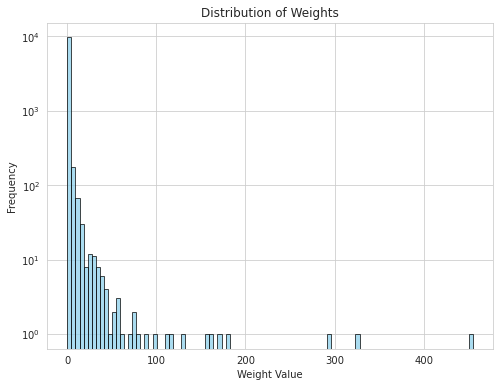

In [32]:
# Evaluate log-likelihoods for MC data
model.eval()
with torch.no_grad():
    mc_transformed, mc_log_det_J = model(mc_data_scaled_tensor)
    real_transformed, real_log_det_J = model(real_data_scaled_tensor)

    # Compute log-likelihoods (log of the transformed densities)
    log_likelihood_mc = -mc_log_det_J
    log_likelihood_real = -real_log_det_J


# Compute weights as the ratio of log-likelihoods
# weights = torch.exp(log_likelihood_real - log_likelihood_mc)
log_likelihood_diff = torch.clamp(log_likelihood_real - log_likelihood_mc, min=-10, max=10)
weights = torch.exp(log_likelihood_diff)


# Normalize the weights (optional but recommended)
# weights /= weights.sum()
weights /= weights.mean()


# Convert weights to numpy for further analysis or use in model training
weights = weights.numpy()

# Reweight MC data based on computed weights
# This can be done by either resampling or using weighted loss functions
reweighted_mc_data = mc_data_scaled.multiply(weights, axis=0)

# Plot the weights as a histogram
plt.figure(figsize=(8, 6))
plt.hist(weights, bins=100, color='skyblue', edgecolor='black', alpha=0.7,log=1)
plt.title('Distribution of Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


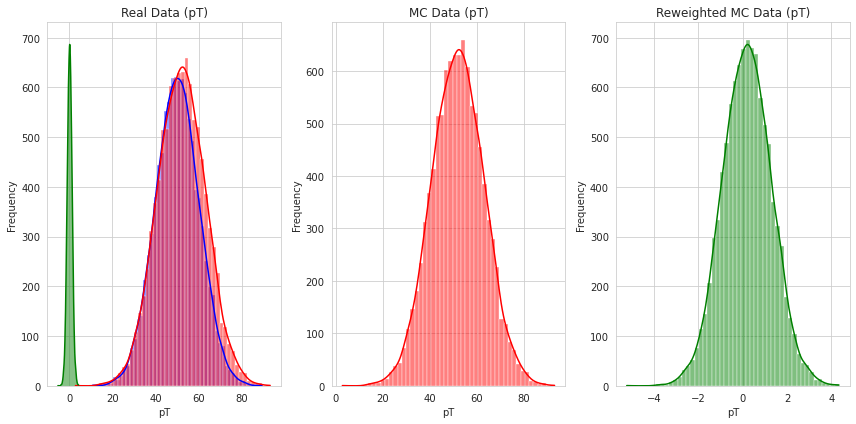

In [31]:
# Assuming real_data, mc_data, and mc_rew are Pandas DataFrames
# For the sake of example, plot the feature `pT` from each dataset

plt.figure(figsize=(12, 6))

# Plot real data
plt.subplot(1, 3, 1)
sns.histplot(real_data['pT'], bins=50, color='blue', kde=True)
sns.histplot(mc_data['pT'], bins=50, color='red', kde=True)
sns.histplot(reweighted_mc_data['pT'],  bins=50, color='green', kde=True)
plt.title('Real Data (pT)')
plt.xlabel('pT')
plt.ylabel('Frequency')

# Plot MC data
plt.subplot(1, 3, 2)

sns.histplot(mc_data['pT'], bins=50, color='red', kde=True)
plt.title('MC Data (pT)')
plt.xlabel('pT')
plt.ylabel('Frequency')

# Plot reweighted MC data
plt.subplot(1, 3, 3)
sns.histplot(reweighted_mc_data['pT'],  bins=50, color='green', kde=True)
plt.title('Reweighted MC Data (pT)')
plt.xlabel('pT')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


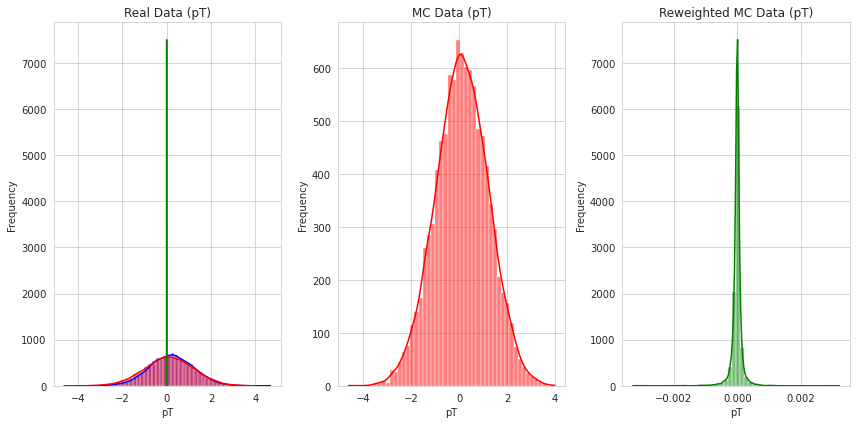

In [15]:
plt.figure(figsize=(12, 6))

# Plot real data
plt.subplot(1, 3, 1)
sns.histplot(real_data['y'], bins=50, color='blue', kde=True)
sns.histplot(mc_data['y'], bins=50, color='red', kde=True)
sns.histplot(reweighted_mc_data['y'],  bins=50, color='green', kde=True)
plt.title('Real Data (pT)')
plt.xlabel('pT')
plt.ylabel('Frequency')

# Plot MC data
plt.subplot(1, 3, 2)

sns.histplot(mc_data['y'], bins=50, color='red', kde=True)
plt.title('MC Data (pT)')
plt.xlabel('pT')
plt.ylabel('Frequency')

# Plot reweighted MC data
plt.subplot(1, 3, 3)
sns.histplot(reweighted_mc_data['y'],  bins=50, color='green', kde=True)
plt.title('Reweighted MC Data (pT)')
plt.xlabel('pT')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Plot reweighted MC data using plt.hist() which directly accepts weights
plt.figure(figsize=(8, 6))
plt.hist(mc_data_scaled['pT'], bins=50, weights=weights, color='green', alpha=0.7, edgecolor='black')
plt.title('Reweighted MC Data (pT)')
plt.xlabel('pT')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
reweighted_mc_data